In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
import altair as alt


import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.neighbors import RadiusNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

alt.renderers.enable('mimetype');
alt.data_transformers.enable('json');
alt.data_transformers.disable_max_rows()

import pickle

import sys
sys.path.insert(1, '../../src')

from preprocessing import*
from xgboost_functions import*
from model_evaluation import*

### Load the data

In [3]:
# Read the flow rates data and select the gauge of interest
flows = read_data("../../data/station_flowrate.csv")
col = '05DF001_flow_m3s-1'
gauge = choose_gauge(flows, col)

In [4]:
narr_dir = "../../data/narr_csvs/05DF001.csv"
gauge_new = add_narr(gauge, narr_dir)

In [5]:
# Choose the summer month and split the data
df_train, df_val, df_test = choose_month_and_split(gauge_new, val_size=214, test_size=214, start_month=4, end_month=10)

### Add different features as inputs and comparison

#### NULL Model (with no predictors)

In [7]:
# Read Null model from the saved pickle files
with open('../../data/pickle/res_null_model_gb.pickle', 'rb') as handle:
    res_null_model = pickle.load(handle)

In [13]:
# calculate the average quantile loss on the validation set for the Null model
null_loss = avg_quantile_loss(res_null_model, df_val, 'flow_record')
print('The average quantile loss on the validation set for the NULL model is', null_loss)

The average quantile loss on the validation set for the NULL model is 27.663


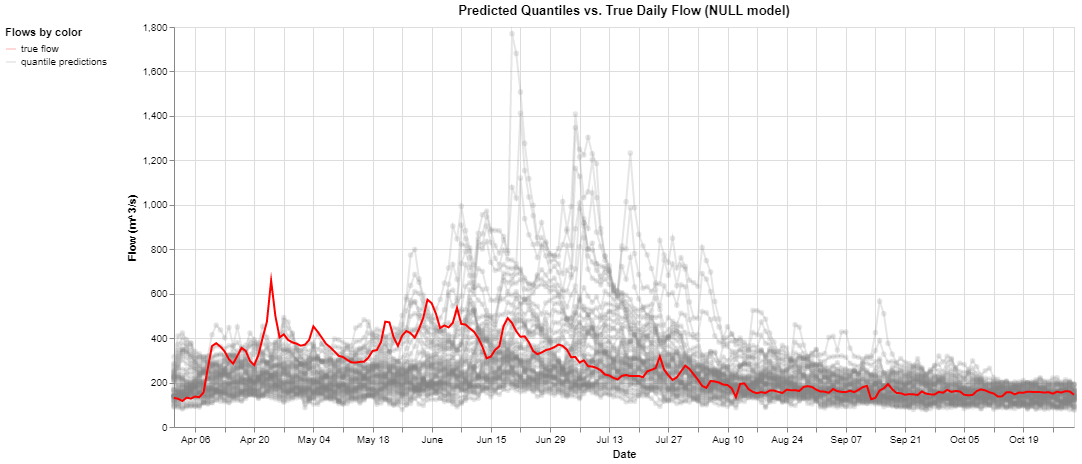

In [14]:
# Plot the predicted quantiles with true flow rates for the null model
plot_quantiles(res_null_model, df_val, set_title = 'Predicted Quantiles vs. True Daily Flow (NULL model)')

#### Model without NARR feature

In [19]:
# get the outputs from the pickle file
with open('../data/pickle/gb_flow_only_results.pickle', 'rb') as handle:
    gb_flow_only_results = pickle.load(handle)
with open('../data/pickle/gb_flow_only_fi.pickle', 'rb') as handle:
    gb_flow_only_fi = pickle.load(handle)

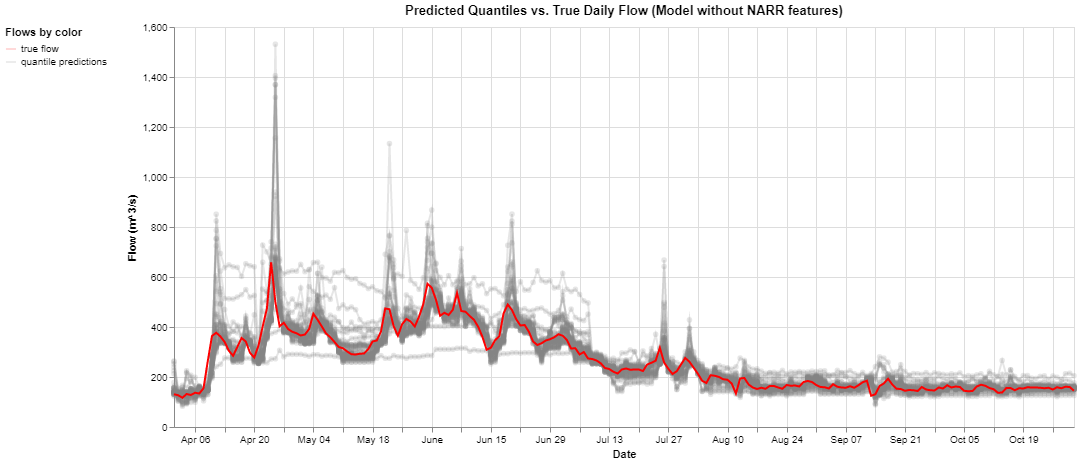

In [20]:
plot_quantiles(gb_flow_only_results, df_val, set_title = 'Predicted Quantiles vs. True Daily Flow (Model without NARR features)')

In [21]:
print(f'The feature importance of the model without NARR features is {gb_flow_only_fi}.')

The feature importance of the model without NARR features is [0.87080981 0.06397688 0.06521332].


In [22]:
# Calculate the average quantile loss on the validation set
without_narr_loss = avg_quantile_loss(gb_flow_only_results, df_val, 'flow_record')
print(f'The average quantile loss of the model without NARR features on the validation set is {without_narr_loss}.')

The average quantile loss of the model without NARR features on the validation set is 7.9676.


> The quantile loss has decreased drastically compared with the null model. At the same time, we can see that there is a one-day lag between the prediction and the actual flow, which is caused by the model being dominated by the first lag of the flow rate.

#### Model with NARR features

In [25]:
# get the outputs from the pickle file
with open('../data/pickle/gb_narr_results.pickle', 'rb') as handle:
    gb_narr_results = pickle.load(handle)
with open('../data/pickle/gb_narr_fi.pickle', 'rb') as handle:
    gb_narr_fi = pickle.load(handle)

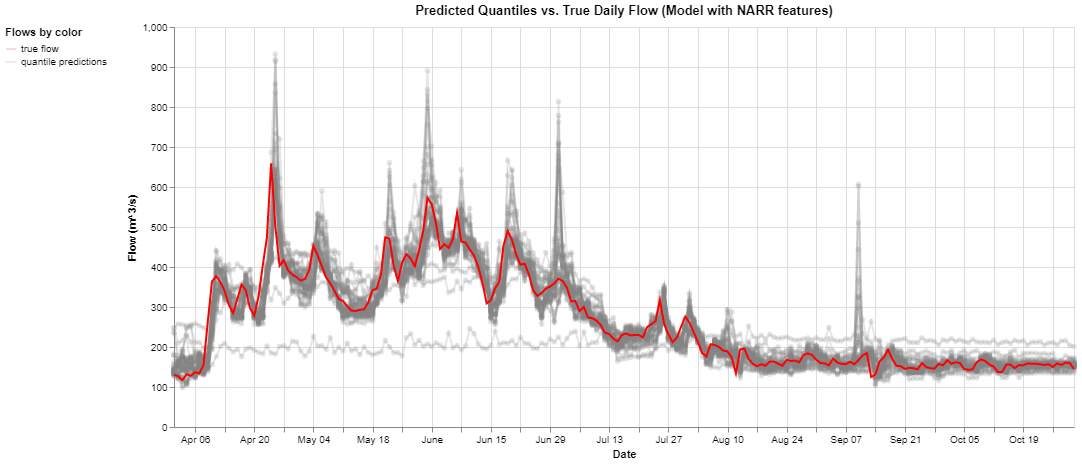

In [26]:
plot_quantiles(gb_narr_results, df_val, set_title = 'Predicted Quantiles vs. True Daily Flow (Model with NARR features)')

In [27]:
print(f'The feature importance of the model with NARR features is {gb_narr_fi}.')

The feature importance of the model with NARR features is [0.78446353 0.02774322 0.02881617 0.02497035 0.02550985 0.02889675
 0.02823448 0.01994693 0.03141872].


In [28]:
# Calculate the average quantile loss on the validation set
with_narr_loss = avg_quantile_loss(gb_narr_results, df_val, 'flow_record')
print(f'The average quantile loss of the model with NARR features on the validation set is {with_narr_loss}.')

The average quantile loss of the model with NARR features on the validation set is 7.9379.


> As we can see that the quantile loss has decreased a little bit with the adding up of the spatial (NARR) features. The first lag of the flow is still playing an significant role here. Even though there is still one-day lag between the predictions and the actual flow, the range of the prediction distribution has decreased a lot. For example, at around Apr.26th, the range has decreased from 1500 to 900 (m^3/s) comparing to the model without NARR features. This narrowing of prediction range can be helpful in the future.



## Conclusion and potential improvements in the future

Here we have only used the past 3 days data of `flow_record`, `soilm` and `acpc`. We believe the model will improve significantly with more feature engineering done in the future. The model can possibly be improved with more training data too, since we only used two years data for training for both of our models here.

The original flow record were used. We have also tried decomposing the flow record data first before feeding into the model, the results wasn't as good as the original flow record. 

Even though Gradient Boosted Trees has the nice built-in loss function for quantiles, it can be computationally expensive especially we have a lot of data in our case. Therefore, we have only run one-step roll forward prediction with daily data here as we didn't have enough computational power and we get similar performance as the Random Forest Regressor. The Gradient Boosted Trees can take a long time to train when we are using hourly data or running multi steps predictions. 

## Comparing Tree-based Models

According to the [test results](https://github.ubc.ca/MDS-2019-20/DSCI_591-BGC/blob/data_product/doc/test_quantile_predictions.ipynb), both Random Forest and Gradient Boosted Trees estimates the population distribution. The predicted distribution of the Gradient Boosted Trees look more like the original distribution than the Random Forest.

In general, the Gradient Boosted Tree has lower average quantile loss compared to the [Random Forest model](https://github.ubc.ca/MDS-2019-20/DSCI_591-BGC/blob/data_product/doc/RF_model.ipynb), especially when the spatial data were not included in the predictors. Meanwhile, it requires more computational power than Random Forest as the Gradient Boosted Trees fits the model each time for every quantile. Although the results of the gradient boosted Trees are very similar as Random Forest, with more powerful computation and better predictors, the gradient boosting model may perform better.